In [ ]:
# Cell 1: Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE


In [ ]:
# Cell 2: Load Dataset
# replace with your actual path
df = pd.read_csv('parkinsons_updrs.data')
print("Original shape:", df.shape)
df.head()


Original shape: (5875, 22)


,subject#,age,sex,test_time,motor_UPDRS,total_UPDRS,Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,...,Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA,NHR,HNR,RPDE,DFA,PPE
0,1,72,0,5.6431,28.199,34.398,0.00662,0.000034,0.00401,0.00317,...,0.230,0.01438,0.01309,0.01662,0.04314,0.014290,21.640,0.41888,0.54842,0.16006
1,1,72,0,12.6660,28.447,34.894,0.00300,0.000017,0.00132,0.00150,...,0.179,0.00994,0.01072,0.01689,0.02982,0.011112,27.183,0.43493,0.56477,0.10810
2,1,72,0,19.6810,28.695,35.389,0.00481,0.000025,0.00205,0.00208,...,0.181,0.00734,0.00844,0.01458,0.02202,0.020220,23.047,0.46222,0.54405,0.21014
3,1,72,0,25.6470,28.905,35.810,0.00528,0.000027,0.00191,0.00264,...,0.327,0.01106,0.01265,0.01963,0.03317,0.027837,24.445,0.48730,0.57794,0.33277
4,1,72,0,33.6420,29.187,36.375,0.00335,0.000020,0.00093,0.00130,...,0.176,0.00679,0.00929,0.01819,0.02036,0.011625,26.126,0.47188,0.56122,0.19361


In [ ]:
# Cell 3: Data Cleaning & Feature Engineering
# 1. Drop NA
df = df.dropna()

# 2. Encode 'sex' if needed
if df['sex'].dtype == 'object':
    df['sex'] = LabelEncoder().fit_transform(df['sex'])

# 3. Binarize motor_UPDRS at median
threshold = df['motor_UPDRS'].median()
df['target'] = (df['motor_UPDRS'] > threshold).astype(int)

# 4. Select features and target
X = df.drop(columns=['su bject#','motor_UPDRS','total_UPDRS','target'])
y = df['target']

# 5. Standardize all features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Features shape:", X_scaled.shape)
print("Target distribution:\n", y.value_counts())


Features shape: (5875, 19)
Target distribution:
 target
0    2939
1    2936
Name: count, dtype: int64


In [ ]:
# Cell 4: Train–Test Split (stratified by target)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)
print("Train size:", X_train.shape, "Test size:", X_test.shape)


Train size: (4700, 19) Test size: (1175, 19)


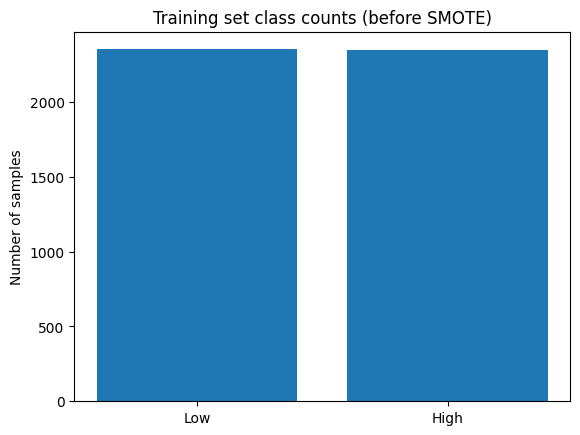

Counts before SMOTE: {'Low': np.int64(2351), 'High': np.int64(2349)}


In [ ]:
# Cell 5: Plot Class Imbalance (before SMOTE)
counts = np.bincount(y_train)
plt.bar(['Low','High'], counts)
plt.title("Training set class counts (before SMOTE)")
plt.ylabel("Number of samples")
plt.show()
print(f"Counts before SMOTE: {dict(zip(['Low','High'], counts))}")


In [ ]:
# Cell 6: Apply SMOTE
sm = SMOTE(random_state=42)
X_train_smote, y_train_smote = sm.fit_resample(X_train, y_train)
print("Counts after SMOTE:", dict(zip(['Low','High'], np.bincount(y_train_smote))))


Counts after SMOTE: {'Low': np.int64(2351), 'High': np.int64(2351)}


In [ ]:
# Cell 7: Baseline SVM models (linear, poly, rbf) without tuning
for kernel in ['linear', 'poly', 'rbf']:
    print(f"\n--- SVM kernel={kernel} ---")
    clf = SVC(kernel=kernel, probability=True, random_state=42)
    clf.fit(X_train_smote, y_train_smote)
    y_pred = clf.predict(X_test)

    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("ROC-AUC:", roc_auc_score(y_test, clf.predict_proba(X_test)[:,1]))



--- SVM kernel=linear ---
Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.60      0.62       588
           1       0.63      0.69      0.66       587

    accuracy                           0.64      1175
   macro avg       0.64      0.64      0.64      1175
weighted avg       0.64      0.64      0.64      1175

Confusion Matrix:
 [[350 238]
 [184 403]]
ROC-AUC: 0.689844592010569

--- SVM kernel=poly ---
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.74      0.77       588
           1       0.76      0.81      0.78       587

    accuracy                           0.78      1175
   macro avg       0.78      0.78      0.78      1175
weighted avg       0.78      0.78      0.78      1175

Confusion Matrix:
 [[437 151]
 [112 475]]
ROC-AUC: 0.86884481220086

--- SVM kernel=rbf ---
Classification Report:
              precision    recall  f1-score   support

         

In [ ]:
print("\n🔹 Tuning Linear SVM")

from sklearn.model_selection import RandomizedSearchCV

param_dist_linear = {
    'C': [0.01, 0.1, 1, 10, 100],
}

random_search_linear = RandomizedSearchCV(
    estimator=SVC(kernel='linear', probability=True, random_state=42),
    param_distributions=param_dist_linear,
    n_iter=5,
    scoring='f1',
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    random_state=42,
    n_jobs=-1,
    verbose=1
)

random_search_linear.fit(X_train_smote, y_train_smote)

# Evaluation
best_linear = random_search_linear.best_estimator_
y_pred_linear = best_linear.predict(X_test)

print("Best Linear Params:", random_search_linear.best_params_)
print("Classification Report:\n", classification_report(y_test, y_pred_linear))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_linear))
print("ROC-AUC:", roc_auc_score(y_test, best_linear.predict_proba(X_test)[:,1]))



🔹 Tuning Linear SVM
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best Linear Params: {'C': 0.01}
Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.62      0.64       588
           1       0.64      0.67      0.66       587

    accuracy                           0.65      1175
   macro avg       0.65      0.65      0.65      1175
weighted avg       0.65      0.65      0.65      1175

Confusion Matrix:
 [[366 222]
 [192 395]]
ROC-AUC: 0.67491221360776


In [ ]:
print("\n🔹 Tuning Polynomial SVM")

param_dist_poly = {
    'C': [0.01, 0.1, 1, 10, 100],
    'degree': [2, 3, 4],
    'gamma': ['scale', 'auto']
}

random_search_poly = RandomizedSearchCV(
    estimator=SVC(kernel='poly', probability=True, random_state=42),
    param_distributions=param_dist_poly,
    n_iter=10,
    scoring='f1',
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    random_state=42,
    n_jobs=-1,
    verbose=1
)

random_search_poly.fit(X_train_smote, y_train_smote)

# Evaluation
best_poly = random_search_poly.best_estimator_
y_pred_poly = best_poly.predict(X_test)

print("Best Polynomial Params:", random_search_poly.best_params_)
print("Classification Report:\n", classification_report(y_test, y_pred_poly))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_poly))
print("ROC-AUC:", roc_auc_score(y_test, best_poly.predict_proba(X_test)[:,1]))



🔹 Tuning Polynomial SVM
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Polynomial Params: {'gamma': 'scale', 'degree': 4, 'C': 100}
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.90      0.86       588
           1       0.89      0.80      0.84       587

    accuracy                           0.85      1175
   macro avg       0.86      0.85      0.85      1175
weighted avg       0.86      0.85      0.85      1175

Confusion Matrix:
 [[530  58]
 [116 471]]
ROC-AUC: 0.7245767131384069


In [ ]:
print("\n🔹 Tuning RBF SVM")

param_dist_rbf = {
    'C': [0.01, 0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1]
}

random_search_rbf = RandomizedSearchCV(
    estimator=SVC(kernel='rbf', probability=True, random_state=42),
    param_distributions=param_dist_rbf,
    n_iter=10,
    scoring='f1',
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    random_state=42,
    n_jobs=-1,
    verbose=1
)

random_search_rbf.fit(X_train_smote, y_train_smote)

# Evaluation
best_rbf = random_search_rbf.best_estimator_
y_pred_rbf = best_rbf.predict(X_test)

print("Best RBF Params:", random_search_rbf.best_params_)
print("Classification Report:\n", classification_report(y_test, y_pred_rbf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rbf))
print("ROC-AUC:", roc_auc_score(y_test, best_rbf.predict_proba(X_test)[:,1]))



🔹 Tuning RBF SVM
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best RBF Params: {'gamma': 1, 'C': 10}
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.88      0.90       588
           1       0.88      0.93      0.90       587

    accuracy                           0.90      1175
   macro avg       0.90      0.90      0.90      1175
weighted avg       0.90      0.90      0.90      1175

Confusion Matrix:
 [[515  73]
 [ 43 544]]
ROC-AUC: 0.9592039541540636


In [ ]:
##  Random Forest Classifier (Standard + Tuned) — Shas Workflow


In [ ]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to balance training data
sm = SMOTE(random_state=42)
X_train_smote, y_train_smote = sm.fit_resample(X_train, y_train)

# Confirm class balance
import pandas as pd
print("Balanced class distribution after SMOTE:")
print(pd.Series(y_train_smote).value_counts())


Balanced class distribution after SMOTE:
target
1    2351
0    2351
Name: count, dtype: int64


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Initialize and train Random Forest
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train_smote, y_train_smote)

# Predict
y_pred_rf = rf_clf.predict(X_test)

# Evaluation
print(" Classification Report (RF - Default):")
print(classification_report(y_test, y_pred_rf))

print(" Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

print(" ROC AUC Score:", roc_auc_score(y_test, rf_clf.predict_proba(X_test)[:, 1]))


 Classification Report (RF - Default):
              precision    recall  f1-score   support

           0       0.95      0.94      0.94       588
           1       0.94      0.95      0.94       587

    accuracy                           0.94      1175
   macro avg       0.94      0.94      0.94      1175
weighted avg       0.94      0.94      0.94      1175

 Confusion Matrix:
[[553  35]
 [ 30 557]]
 ROC AUC Score: 0.986921855624703


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best RF Parameters (RandomizedSearchCV): {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 20, 'bootstrap': True}

 Classification Report (Tuned RF):
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       588
           1       0.99      0.98      0.99       587

    accuracy                           0.99      1175
   macro avg       0.99      0.99      0.99      1175
weighted avg       0.99      0.99      0.99      1175

 F1 Score: 0.9871904355251921
 ROC AUC Score: 0.9992249881213132


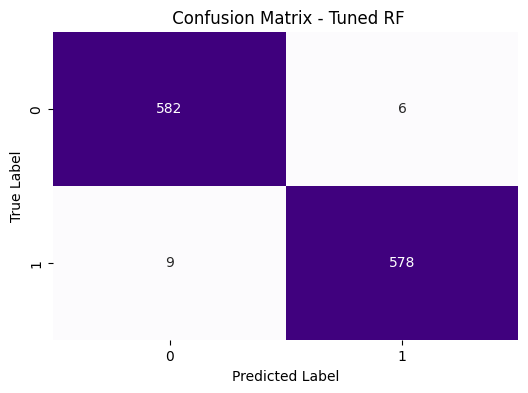

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Hyperparameter space (same as before)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

# 2. CV splitter
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 3. RandomizedSearchCV setup & fit
rf_random = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=param_grid,
    n_iter=20,
    scoring='f1',
    cv=cv,
    n_jobs=-1,
    random_state=42,
    verbose=1
)
rf_random.fit(X_train_smote, y_train_smote)

print("Best RF Parameters (RandomizedSearchCV):", rf_random.best_params_)

# 4. Extract best model and predict
best_rf_model = rf_random.best_estimator_
y_pred_best = best_rf_model.predict(X_test)

# 5. Evaluation metrics
print("\n Classification Report (Tuned RF):")
print(classification_report(y_test, y_pred_best))
print(" F1 Score:", f1_score(y_test, y_pred_best))
print(" ROC AUC Score:", roc_auc_score(y_test, best_rf_model.predict_proba(X_test)[:, 1]))

# 6. Confusion matrix heatmap
cm = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', cbar=False)
plt.title(" Confusion Matrix - Tuned RF")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [ ]:
#DEScision TREE
#Classifier

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Initialize and train Decision Tree on SMOTE-balanced data
dt_clf = DecisionTreeClassifier(random_state=42)
dt_clf.fit(X_train_smote, y_train_smote)

# Predict on test data
y_pred_dt = dt_clf.predict(X_test)

# Evaluation
print(" Classification Report (Decision Tree - Default):")
print(classification_report(y_test, y_pred_dt))
print(" Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_dt))
print(" ROC AUC Score:", roc_auc_score(y_test, dt_clf.predict_proba(X_test)[:, 1]))


 Classification Report (Decision Tree - Default):
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       588
           1       0.98      0.98      0.98       587

    accuracy                           0.98      1175
   macro avg       0.98      0.98      0.98      1175
weighted avg       0.98      0.98      0.98      1175

 Confusion Matrix:
[[576  12]
 [ 12 575]]
 ROC AUC Score: 0.9795744532906859


In [ ]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold

# Hyperparameter space for Decision Tree
dt_param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2']
}

# Stratified CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Randomized Search setup
dt_random = RandomizedSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_distributions=dt_param_grid,
    n_iter=20,
    scoring='f1',
    cv=cv,
    n_jobs=-1,
    random_state=42,
    verbose=1
)

# Fit on SMOTE-balanced training data
dt_random.fit(X_train_smote, y_train_smote)
print(" Best DT Parameters (RandomizedSearchCV):", dt_random.best_params_)



Fitting 5 folds for each of 20 candidates, totalling 100 fits
 Best DT Parameters (RandomizedSearchCV): {'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 20, 'criterion': 'entropy'}



 Classification Report (Tuned DT):
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       588
           1       0.98      0.98      0.98       587

    accuracy                           0.98      1175
   macro avg       0.98      0.98      0.98      1175
weighted avg       0.98      0.98      0.98      1175

 F1 Score: 0.9794871794871794
 ROC AUC Score: 0.9795715560500179


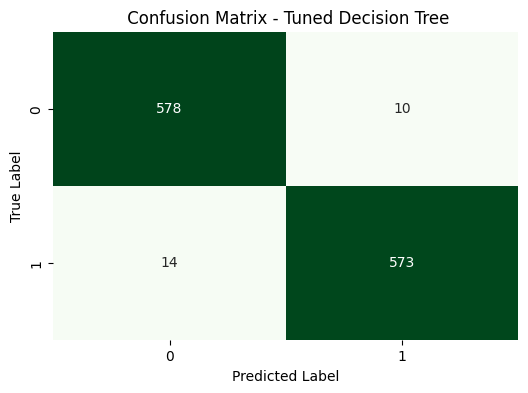

In [ ]:
# Use the best model found
best_dt_model = dt_random.best_estimator_

# Predict on test data
y_pred_best_dt = best_dt_model.predict(X_test)

# Evaluation
print("\n Classification Report (Tuned DT):")
print(classification_report(y_test, y_pred_best_dt))
print(" F1 Score:", f1_score(y_test, y_pred_best_dt))
print(" ROC AUC Score:", roc_auc_score(y_test, best_dt_model.predict_proba(X_test)[:, 1]))

# Confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt
cm_dt = confusion_matrix(y_test, y_pred_best_dt)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Greens', cbar=False)
plt.title(" Confusion Matrix - Tuned Decision Tree")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [ ]:
##KNN
#Classifier

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Initialize and train KNN (default params)
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_smote, y_train_smote)

# Predict
y_pred_knn = knn_clf.predict(X_test)

# Evaluation
print(" Classification Report (KNN - Default):")
print(classification_report(y_test, y_pred_knn))

print(" Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_knn))

print(" ROC AUC Score:", roc_auc_score(y_test, knn_clf.predict_proba(X_test)[:, 1]))


 Classification Report (KNN - Default):
              precision    recall  f1-score   support

           0       0.88      0.88      0.88       588
           1       0.88      0.88      0.88       587

    accuracy                           0.88      1175
   macro avg       0.88      0.88      0.88      1175
weighted avg       0.88      0.88      0.88      1175

 Confusion Matrix:
[[516  72]
 [ 72 515]]
 ROC AUC Score: 0.9476207859634483


In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Define param grid
knn_param_grid = {
    'n_neighbors': list(range(3, 16, 2)),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# RandomizedSearchCV
knn_random = RandomizedSearchCV(
    estimator=KNeighborsClassifier(),
    param_distributions=knn_param_grid,
    n_iter=20,
    scoring='f1',
    cv=cv,
    n_jobs=-1,
    random_state=42,
    verbose=1
)

knn_random.fit(X_train_smote, y_train_smote)
print(" Best KNN Parameters (RandomizedSearchCV):", knn_random.best_params_)


Fitting 5 folds for each of 20 candidates, totalling 100 fits
 Best KNN Parameters (RandomizedSearchCV): {'weights': 'distance', 'n_neighbors': 5, 'metric': 'manhattan'}


 Classification Report (Tuned KNN):
               precision    recall  f1-score   support

           0       0.90      0.88      0.89       588
           1       0.89      0.90      0.89       587

    accuracy                           0.89      1175
   macro avg       0.89      0.89      0.89      1175
weighted avg       0.89      0.89      0.89      1175

 F1 Score: 0.8926458157227388
 ROC AUC Score: 0.9604381786786265


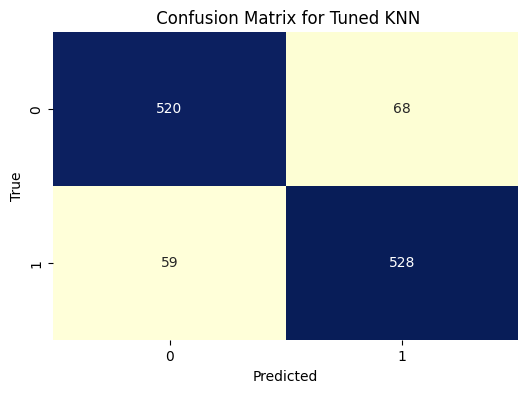

In [ ]:
from sklearn.metrics import f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# Use the best model found
best_knn_model = knn_random.best_estimator_

# Predict
y_pred = best_knn_model.predict(X_test)

# Print metrics
print(" Classification Report (Tuned KNN):\n", classification_report(y_test, y_pred))
print(" F1 Score:", f1_score(y_test, y_pred))
print(" ROC AUC Score:", roc_auc_score(y_test, best_knn_model.predict_proba(X_test)[:, 1]))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', cbar=False)
plt.title(" Confusion Matrix for Tuned KNN")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [ ]:
#Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

#  Initialize and train Logistic Regression on SMOTE data
lr_clf = LogisticRegression(max_iter=1000, random_state=42)
lr_clf.fit(X_train_smote, y_train_smote)

#  Predict on test data
y_pred_lr = lr_clf.predict(X_test)

#  Evaluate
print(" Classification Report (LR - Default):")
print(classification_report(y_test, y_pred_lr))

print(" Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_lr))

print(" ROC AUC Score:", roc_auc_score(y_test, lr_clf.predict_proba(X_test)[:, 1]))


 Classification Report (LR - Default):
              precision    recall  f1-score   support

           0       0.64      0.63      0.64       588
           1       0.64      0.65      0.64       587

    accuracy                           0.64      1175
   macro avg       0.64      0.64      0.64      1175
weighted avg       0.64      0.64      0.64      1175

 Confusion Matrix:
[[369 219]
 [205 382]]
 ROC AUC Score: 0.6951407479516508


In [ ]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold

#  Logistic Regression hyperparameter grid
lr_param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

#  Stratified CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

#  Randomized Search
lr_random = RandomizedSearchCV(
    estimator=LogisticRegression(max_iter=1000, random_state=42),
    param_distributions=lr_param_grid,
    n_iter=10,
    scoring='f1',
    cv=cv,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

lr_random.fit(X_train_smote, y_train_smote)
print(" Best LR Parameters (RandomizedSearchCV):", lr_random.best_params_)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
 Best LR Parameters (RandomizedSearchCV): {'solver': 'saga', 'penalty': 'l1', 'C': 0.1}


 Classification Report (Tuned LR):
               precision    recall  f1-score   support

           0       0.64      0.64      0.64       588
           1       0.64      0.65      0.64       587

    accuracy                           0.64      1175
   macro avg       0.64      0.64      0.64      1175
weighted avg       0.64      0.64      0.64      1175

 F1 Score: 0.6434634974533107


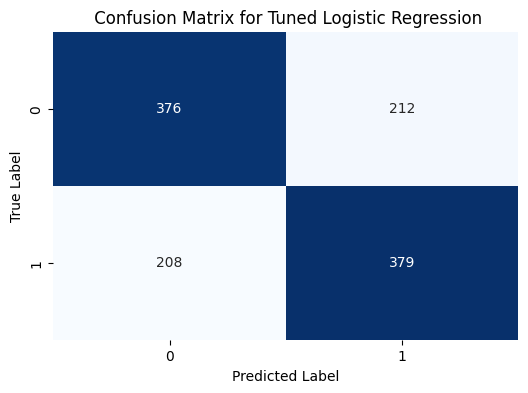

In [ ]:
from sklearn.metrics import f1_score
import seaborn as sns
import matplotlib.pyplot as plt

#  Best model
best_lr_model = lr_random.best_estimator_

#  Predict
y_pred_best_lr = best_lr_model.predict(X_test)

#  Metrics
print(" Classification Report (Tuned LR):\n", classification_report(y_test, y_pred_best_lr))
print(" F1 Score:", f1_score(y_test, y_pred_best_lr))

#  Confusion Matrix
cm = confusion_matrix(y_test, y_pred_best_lr)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title(" Confusion Matrix for Tuned Logistic Regression")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


Since no much change in accuracy with normal lr ,lets add polynomialfeatures

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

# Generate polynomial features (degree=2 is usually a good start)
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train_smote)
X_test_poly = poly.transform(X_test)


 Classification Report (LogReg + Poly):
              precision    recall  f1-score   support

           0       0.78      0.76      0.77       588
           1       0.77      0.79      0.78       587

    accuracy                           0.77      1175
   macro avg       0.77      0.77      0.77      1175
weighted avg       0.77      0.77      0.77      1175

 ROC AUC Score: 0.8487466536870283
 Confusion Matrix:


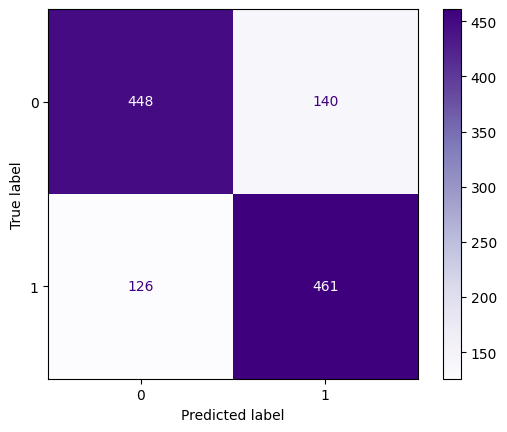

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Train
logreg_poly = LogisticRegression(max_iter=1000, random_state=42)
logreg_poly.fit(X_train_poly, y_train_smote)

# Predict
y_pred_poly = logreg_poly.predict(X_test_poly)

# Evaluation
print(" Classification Report (LogReg + Poly):")
print(classification_report(y_test, y_pred_poly))

print(" ROC AUC Score:", roc_auc_score(y_test, logreg_poly.predict_proba(X_test_poly)[:, 1]))

print(" Confusion Matrix:")
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_poly, cmap='Purples')


In [ ]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression

# Set up hyperparameter grid
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],  # 'l1' requires solver='liblinear', but poly features often need 'lbfgs'
    'solver': ['lbfgs']
}

# Cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Grid Search setup
logreg_grid = GridSearchCV(
    LogisticRegression(max_iter=1000, random_state=42),
    param_grid=param_grid_lr,
    scoring='f1',
    cv=cv,
    n_jobs=-1,
    verbose=1
)

# Fit on polynomial features
logreg_grid.fit(X_train_poly, y_train_smote)

# Best model
best_logreg_poly = logreg_grid.best_estimator_

print(" Best Parameters (Logistic Regression with Poly):", logreg_grid.best_params_)


Fitting 5 folds for each of 4 candidates, totalling 20 fits
 Best Parameters (Logistic Regression with Poly): {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


 Classification Report (Tuned LogReg + Poly):
              precision    recall  f1-score   support

           0       0.79      0.77      0.78       588
           1       0.77      0.80      0.79       587

    accuracy                           0.78      1175
   macro avg       0.78      0.78      0.78      1175
weighted avg       0.78      0.78      0.78      1175

 ROC AUC Score: 0.8540312206654382
 Confusion Matrix:


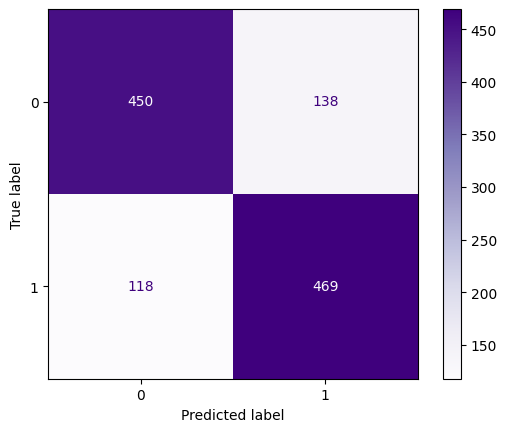

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Predict
y_pred_poly_tuned = best_logreg_poly.predict(X_test_poly)

# Evaluation
print(" Classification Report (Tuned LogReg + Poly):")
print(classification_report(y_test, y_pred_poly_tuned))

print(" ROC AUC Score:", roc_auc_score(y_test, best_logreg_poly.predict_proba(X_test_poly)[:, 1]))

print(" Confusion Matrix:")
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_poly_tuned, cmap='Purples')


In [ ]:
#Naive Bayes Classifier method

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

#  Initialize and train the Gaussian Naive Bayes model
nb_clf = GaussianNB()
nb_clf.fit(X_train_smote, y_train_smote)

#  Predict on test set
y_pred_nb = nb_clf.predict(X_test)

#  Evaluation
print(" Classification Report (Naive Bayes):")
print(classification_report(y_test, y_pred_nb))

print(" Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_nb))

print(" ROC AUC Score:", roc_auc_score(y_test, nb_clf.predict_proba(X_test)[:, 1]))


 Classification Report (Naive Bayes):
              precision    recall  f1-score   support

           0       0.53      0.90      0.67       588
           1       0.67      0.21      0.32       587

    accuracy                           0.55      1175
   macro avg       0.60      0.55      0.49      1175
weighted avg       0.60      0.55      0.49      1175

 Confusion Matrix:
[[528  60]
 [464 123]]
 ROC AUC Score: 0.6326849308718376


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB

#  Define parameter grid
param_grid_nb = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
}

#  Setup GridSearchCV
nb_grid = GridSearchCV(
    estimator=GaussianNB(),
    param_grid=param_grid_nb,
    scoring='f1',
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    verbose=1,
    n_jobs=-1
)

#  Fit the model
nb_grid.fit(X_train_smote, y_train_smote)

#  Best params
print(" Best Parameters (Naive Bayes):", nb_grid.best_params_)


Fitting 5 folds for each of 5 candidates, totalling 25 fits
 Best Parameters (Naive Bayes): {'var_smoothing': 1e-09}


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

#  Use the best model from GridSearchCV
best_nb_model = nb_grid.best_estimator_

#  Predict on test set
y_pred_nb_tuned = best_nb_model.predict(X_test)

#  Evaluation
print(" Classification Report (Tuned Naive Bayes):")
print(classification_report(y_test, y_pred_nb_tuned))

print(" Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_nb_tuned))

print(" ROC AUC Score:", roc_auc_score(y_test, best_nb_model.predict_proba(X_test)[:, 1]))


 Classification Report (Tuned Naive Bayes):
              precision    recall  f1-score   support

           0       0.53      0.90      0.67       588
           1       0.67      0.21      0.32       587

    accuracy                           0.55      1175
   macro avg       0.60      0.55      0.49      1175
weighted avg       0.60      0.55      0.49      1175

 Confusion Matrix:
[[528  60]
 [464 123]]
 ROC AUC Score: 0.6326849308718376


Since accuracy is less and not improved with hpt lets use multinomial naive bayes


In [ ]:
from sklearn.preprocessing import KBinsDiscretizer

# Discretize to convert continuous features to integer bins
kbins = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='quantile')

# Fit on training data and transform both train/test
X_train_binned = kbins.fit_transform(X_train_smote)
X_test_binned = kbins.transform(X_test)


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 1 are removed. Consider decreasing the number of bins.
  warnings.warn(


In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Train Multinomial Naive Bayes
nb_clf = MultinomialNB()
nb_clf.fit(X_train_binned, y_train_smote)

# Predict on test data
y_pred_nb = nb_clf.predict(X_test_binned)

# Evaluate
print(" Classification Report (MultinomialNB):")
print(classification_report(y_test, y_pred_nb))

print(" Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_nb))

print(" ROC AUC Score:", roc_auc_score(y_test, nb_clf.predict_proba(X_test_binned)[:, 1]))


 Classification Report (MultinomialNB):
              precision    recall  f1-score   support

           0       0.60      0.56      0.58       588
           1       0.59      0.63      0.61       587

    accuracy                           0.59      1175
   macro avg       0.59      0.59      0.59      1175
weighted avg       0.59      0.59      0.59      1175

 Confusion Matrix:
[[328 260]
 [217 370]]
 ROC AUC Score: 0.6430280800565542


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB

# Define parameter grid for alpha (smoothing)
param_grid_nb = {
    'alpha': [0.001, 0.01, 0.1, 1.0, 5.0, 10.0]
}

# Grid search
nb_grid = GridSearchCV(
    estimator=MultinomialNB(),
    param_grid=param_grid_nb,
    scoring='f1',
    cv=5,
    n_jobs=-1,
    verbose=1
)

nb_grid.fit(X_train_binned, y_train_smote)

# Best parameters
print(" Best Parameters for MultinomialNB:", nb_grid.best_params_)


Fitting 5 folds for each of 6 candidates, totalling 30 fits
 Best Parameters for MultinomialNB: {'alpha': 0.001}


In [ ]:
# Use best estimator
best_nb = nb_grid.best_estimator_

# Predict
y_pred_best_nb = best_nb.predict(X_test_binned)

# Evaluate
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

print(" Classification Report (Tuned MultinomialNB):")
print(classification_report(y_test, y_pred_best_nb))

print(" Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_best_nb))

print(" ROC AUC Score:", roc_auc_score(y_test, best_nb.predict_proba(X_test_binned)[:, 1]))


 Classification Report (Tuned MultinomialNB):
              precision    recall  f1-score   support

           0       0.60      0.56      0.58       588
           1       0.59      0.63      0.61       587

    accuracy                           0.59      1175
   macro avg       0.59      0.59      0.59      1175
weighted avg       0.59      0.59      0.59      1175

 Confusion Matrix:
[[328 260]
 [217 370]]
 ROC AUC Score: 0.6430222855752181


In [ ]:
#XG-Boost Method

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Initialize and train XGBoost
xgb_clf = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_clf.fit(X_train_smote, y_train_smote)

# Predict
y_pred_xgb = xgb_clf.predict(X_test)

# Evaluation
print(" Classification Report (XGBoost - Default):")
print(classification_report(y_test, y_pred_xgb))

print(" Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb))

print(" ROC AUC Score:", roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:, 1]))


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:54:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


 Classification Report (XGBoost - Default):
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       588
           1       0.99      1.00      0.99       587

    accuracy                           0.99      1175
   macro avg       0.99      0.99      0.99      1175
weighted avg       0.99      0.99      0.99      1175

 Confusion Matrix:
[[583   5]
 [  2 585]]
 ROC AUC Score: 0.9997015842111971


In [ ]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold

# Param grid for tuning
xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 1, 5]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

xgb_random = RandomizedSearchCV(
    estimator=XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
    param_distributions=xgb_param_grid,
    n_iter=20,
    scoring='f1',
    n_jobs=-1,
    cv=cv,
    verbose=1,
    random_state=42
)

xgb_random.fit(X_train_smote, y_train_smote)

print(" Best XGBoost Parameters:", xgb_random.best_params_)


Fitting 5 folds for each of 20 candidates, totalling 100 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:55:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


 Best XGBoost Parameters: {'subsample': 0.6, 'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.2, 'gamma': 0, 'colsample_bytree': 0.6}


In [ ]:
# Best tuned model
best_xgb = xgb_random.best_estimator_

# Predict on test
y_pred_xgb_tuned = best_xgb.predict(X_test)

# Evaluation
print("Classification Report (XGBoost - Tuned):")
print(classification_report(y_test, y_pred_xgb_tuned))

print(" Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb_tuned))

print(" ROC AUC Score:", roc_auc_score(y_test, best_xgb.predict_proba(X_test)[:, 1]))


Classification Report (XGBoost - Tuned):
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       588
           1       0.98      0.99      0.99       587

    accuracy                           0.99      1175
   macro avg       0.99      0.99      0.99      1175
weighted avg       0.99      0.99      0.99      1175

 Confusion Matrix:
[[577  11]
 [  5 582]]
 ROC AUC Score: 0.9987715699567732


In [ ]:
#AdaBoost

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

#  Initialize AdaBoost with default base estimator (DecisionTreeClassifier(max_depth=1))
ada_clf = AdaBoostClassifier(random_state=42)
ada_clf.fit(X_train_smote, y_train_smote)

#  Predict on test data
y_pred_ada = ada_clf.predict(X_test)

#  Evaluation
print(" Classification Report (AdaBoost - Default):")
print(classification_report(y_test, y_pred_ada))

print(" Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_ada))

print(" ROC AUC Score:", roc_auc_score(y_test, ada_clf.predict_proba(X_test)[:, 1]))


 Classification Report (AdaBoost - Default):
              precision    recall  f1-score   support

           0       0.75      0.72      0.73       588
           1       0.73      0.76      0.74       587

    accuracy                           0.74      1175
   macro avg       0.74      0.74      0.74      1175
weighted avg       0.74      0.74      0.74      1175

 Confusion Matrix:
[[424 164]
 [142 445]]
 ROC AUC Score: 0.8080244874781258


In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# 3-fold Stratified CV
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Base estimator
base_estimator = DecisionTreeClassifier(random_state=42)

# Hyperparameter grid (for GridSearch)
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2, 0.5, 1.0],
    'estimator__max_depth': [1, 2, 3],
    'estimator__min_samples_split': [2, 5]
}

# Use GridSearchCV with the new AdaBoost estimator param
ada_grid = GridSearchCV(
    estimator=AdaBoostClassifier(estimator=base_estimator, random_state=42),
    param_grid=param_grid,
    scoring='f1',
    cv=cv,
    n_jobs=-1,
    verbose=2
)

# Fit to SMOTE-applied training data
ada_grid.fit(X_train_smote, y_train_smote)

# Output best parameters
print(" Best AdaBoost Parameters:", ada_grid.best_params_)


Fitting 3 folds for each of 90 candidates, totalling 270 fits
 Best AdaBoost Parameters: {'estimator__max_depth': 3, 'estimator__min_samples_split': 2, 'learning_rate': 1.0, 'n_estimators': 200}


 Classification Report (AdaBoost):
              precision    recall  f1-score   support

           0       0.90      0.90      0.90       588
           1       0.90      0.89      0.90       587

    accuracy                           0.90      1175
   macro avg       0.90      0.90      0.90      1175
weighted avg       0.90      0.90      0.90      1175

 ROC AUC Score: 0.9626560164099712


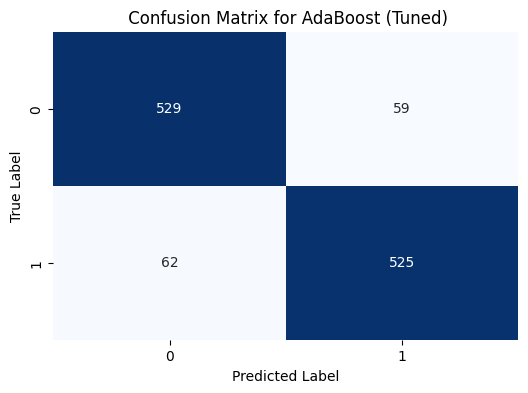

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

# Use best estimator from tuning
best_ada_model = ada_random.best_estimator_

#  Predict on test data
y_pred_ada = best_ada_model.predict(X_test)

#  Evaluation metrics
print(" Classification Report (AdaBoost):")
print(classification_report(y_test, y_pred_ada))

print(" ROC AUC Score:", roc_auc_score(y_test, best_ada_model.predict_proba(X_test)[:, 1]))

#  Confusion Matrix
cm = confusion_matrix(y_test, y_pred_ada)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title(" Confusion Matrix for AdaBoost (Tuned)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()
